# Extremes - Demo

In [16]:
import autoroot
import ee
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
from scipy.stats import rv_histogram, genextreme, genpareto
from bayesevt._src.geoprocessing.math import safe_reciprocal
from geo_toolz._src.masks.country import add_country_mask
from geo_toolz._src.masks.land import add_land_mask
from geo_toolz._src.masks.ocean import add_ocean_mask
from geo_toolz._src.validation.coords import validate_longitude, validate_latitude
from geo_toolz._src.encoders.time import time_rescale, time_unrescale
from geo_toolz._src.discretize.grid import RegularLonLat
from geo_toolz._src.data.reanalysis.gee import download_era5_gee
from geo_toolz.extremes import calculate_block_maxima_ts, calculate_pot_quantile, calculate_pot_ts, calculate_pp_counts_ts, calculate_pp_stats_ts
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS



import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
# create bounding box
gbox = RegularLonLat.init_from_country("E", 1/4)

In [3]:
ds = download_era5_gee("era5_daily", gbox)
ds

<xarray.Dataset> Size: 891MB
Dimensions:                     (time: 15165, lon: 51, lat: 32)
Coordinates:
  * time                        (time) datetime64[ns] 121kB 1979-01-02 ... 20...
  * lon                         (lon) float32 204B -9.375 -9.125 ... 2.875 3.125
  * lat                         (lat) float32 128B 43.62 43.38 ... 36.12 35.88
Data variables:
    mean_2m_air_temperature     (time, lon, lat) float32 99MB ...
    minimum_2m_air_temperature  (time, lon, lat) float32 99MB ...
    maximum_2m_air_temperature  (time, lon, lat) float32 99MB ...
    dewpoint_2m_temperature     (time, lon, lat) float32 99MB ...
    total_precipitation         (time, lon, lat) float32 99MB ...
    surface_pressure            (time, lon, lat) float32 99MB ...
    mean_sea_level_pressure     (time, lon, lat) float32 99MB ...
    u_component_of_wind_10m     (time, lon, lat) float32 99MB ...
    v_component_of_wind_10m     (time, lon, lat) float32 99MB ...
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [4]:
def preprocess(ds):
    # select variable
    ds = ds[["maximum_2m_air_temperature"]]
    ds = ds.rename({"maximum_2m_air_temperature": "t2m_max"})
    
    # validate units
    ds = ds.pint.quantify({"t2m_max": "kelvin"})
    ds["t2m_max"] = ds["t2m_max"].pint.to("degC")
    ds = ds.pint.dequantify()
    
    # validate coordinates
    ds = validate_latitude(ds)
    ds = validate_longitude(ds)

    return ds


In [5]:
%%time
# preprocess data
ds = preprocess(ds)
# add country mask
ds = add_country_mask(ds, country="Spain")
ds

CPU times: user 4.26 s, sys: 1.32 s, total: 5.58 s
Wall time: 25.8 s


<xarray.Dataset> Size: 99MB
Dimensions:     (time: 15165, lon: 51, lat: 32)
Coordinates:
  * time        (time) datetime64[ns] 121kB 1979-01-02 1979-01-03 ... 2020-07-09
  * lon         (lon) float32 204B -9.375 -9.125 -8.875 ... 2.625 2.875 3.125
  * lat         (lat) float32 128B 43.62 43.38 43.12 42.88 ... 36.38 36.12 35.88
    spain_mask  (lat, lon) int16 3kB 0 0 0 0 0 1 1 1 1 0 ... 0 0 0 0 0 0 0 0 0 0
Data variables:
    t2m_max     (time, lon, lat) float32 99MB 13.11 13.28 13.21 ... 38.16 37.06
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

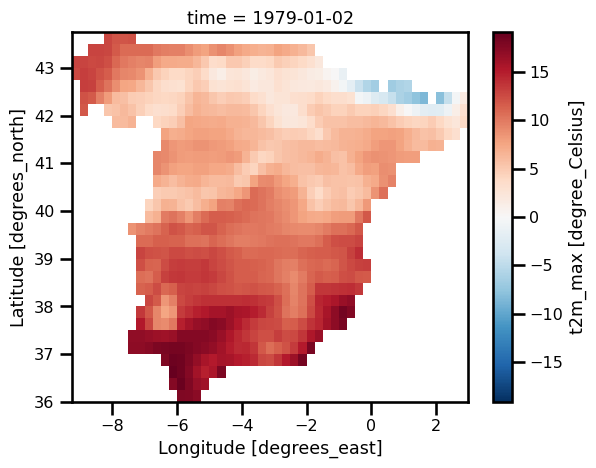

In [6]:
ds.isel(time=0).where(ds.spain_mask==1, drop=True).t2m_max.plot.pcolormesh(x="lon", y="lat")

## Peak Over Threshold

In [10]:
ds_madrid = ds.sel(lon=-3.703790, lat=40.416775, method="nearest")

In [19]:
# # calculate threshold for pot
threshold = calculate_pot_quantile(ds_madrid.t2m_max, quantile=0.98)
# # select remaining (dont drop)
# extremes_pot = ds_madrid.t2m_max.where(ds_madrid.t2m_max >= threshold, drop=True)

extremes_madrid = calculate_pot_ts(ds_madrid.t2m_max, quantile=0.98, decluster_freq=None)
print(f"# Extremes: {extremes_madrid.shape}")

# Extremes: (304,)


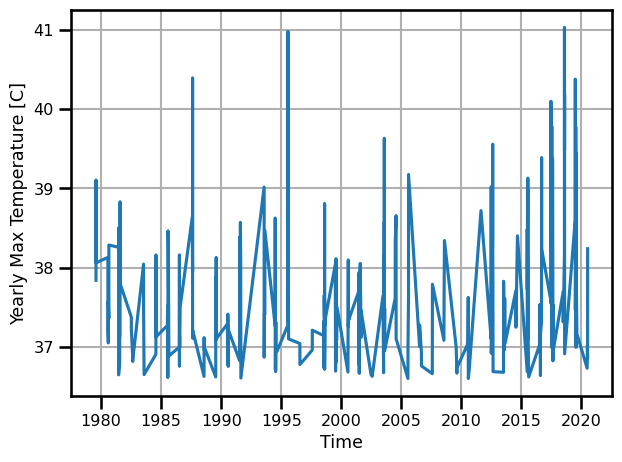

In [12]:
fig, ax = plt.subplots()

extremes_madrid.plot(ax=ax)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]",
    # ylim=[threshold, 42],
    title=""
)
plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()

## Extremes

In [15]:
y = extremes_madrid.values

In [43]:
# fit parameters to data
params = genpareto.fit(y, floc=threshold[0], method="MLE")
# params = genpareto.fit(y, loc=threshold[0], method="MLE")
model = genpareto(*params)
print("Parameters (MLE):")
print(f"Shape - ξ: {params[0]:.4f}")
print(f"Loc   - μ: {params[1]:.4f}")
print(f"Scale - σ: {params[2]:.4f}")

Parameters (MLE):
Shape - ξ: -0.1851
Loc   - μ: 36.5980
Scale - σ: 1.2291


### CDF

In [36]:
# create a length of the domain
y_domain = np.linspace(y.min(), y.max(), 1000)
# get the PDF of the distribution
y_pdf = genpareto.pdf(y_domain, *params)

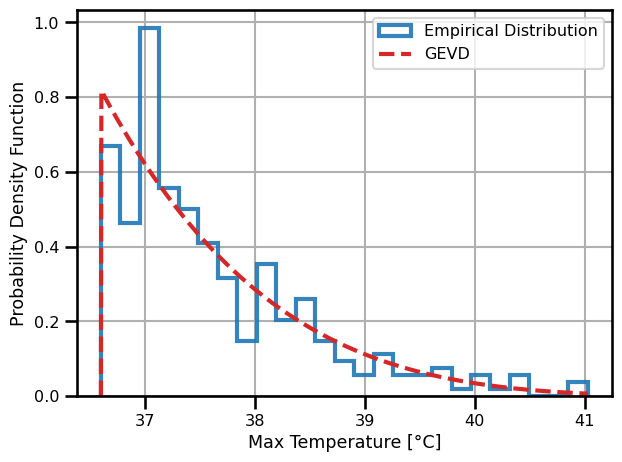

In [37]:
fig, ax = plt.subplots()

ax.hist(y, bins=25, rwidth=2, alpha=0.9, cumulative=False, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(y_domain, y_pdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Max Temperature [°C]",
    ylabel="Probability Density Function",
)

plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

### PDF

In [38]:
# get the CDF of the distribution
y_cdf = genpareto.cdf(y_domain, *params)

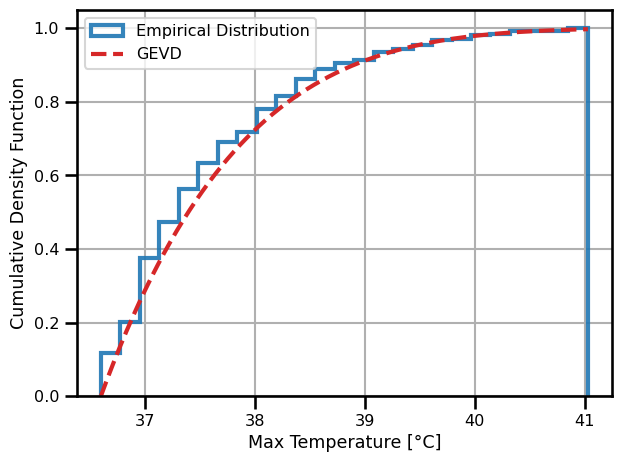

In [39]:
fig, ax = plt.subplots()

ax.hist(y, bins=25, rwidth=2, alpha=0.9, cumulative=True, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(y_domain, y_cdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Max Temperature [°C]",
    ylabel="Cumulative Density Function",
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

## Return Period

In [40]:
# simple return periods
return_periods = np.logspace(-0.999, 2, 100)
# calculate
return_levels = genpareto.isf(1/return_periods, *params)

In [41]:
ds_results = xr.Dataset(
    {
        "return_levels": (("return_periods"), return_levels),
        "shape": (("sample"), [params[0]]),
        "location": (("sample"), [params[1]]),
        "scale": (("sample"), [params[2]]),
    },
    coords = {
        "return_periods": return_periods,
        "sample": [0]
    }
)
ds_results.attrs["inference"] = "mle"
ds_results.attrs["distribution"] = "gpd"
ds_results

<xarray.Dataset> Size: 2kB
Dimensions:         (return_periods: 100, sample: 1)
Coordinates:
  * return_periods  (return_periods) float64 800B 0.1002 0.1075 ... 93.26 100.0
  * sample          (sample) int64 8B 0
Data variables:
    return_levels   (return_periods) float64 800B nan nan nan ... 40.38 40.42
    shape           (sample) float64 8B -0.1802
    location        (sample) float64 8B 36.6
    scale           (sample) float64 8B 1.219
Attributes:
    inference:     mle
    distribution:  gpd

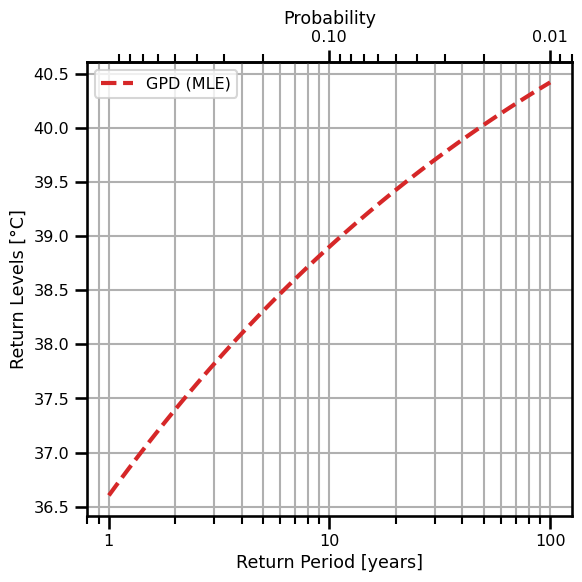

In [42]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    return_periods, return_levels, 
    linestyle="--", linewidth=3, color="tab:red",
    label="GPD (MLE)",
)

ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels [°C]",
    xscale="log",
)

secax = ax.secondary_xaxis("top", functions=(safe_reciprocal, safe_reciprocal))
secax.set_xlabel("Probability")
secax.set_xticks([0.1, 0.01])

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
secax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()